In [96]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import contextlib
import multiprocessing as mp
from scipy.stats import gmean
from quasinet.utils import sample_from_dict

In [42]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/PTSD_cognet_test_processed.csv")

In [ ]:
def fit():
    

In [43]:
# USES COGNET (model_obj)

Tr.fit(modelpath="tmp_Qnet2.joblib")

In [82]:
# make a copy of dissonance using the code that calls Cognet
Tr.getDissonance(outfile="mpi_tmp/PTSD_dissonance_matrix2.csv")
dissonance_cognet = Tr.dissonance

In [83]:
def mp_compute(samples,
               max_processes,
               func, 
               cols,
               outfile, 
               args=[]):
    """
    COPIED FROM COGNET: does not call anything in cognet
    
    Compute desired function through multiprocessing and save result to csv.

    Args:
        samples (2d array): 2 dimensional numpy array
        processes (int): number of processes to use.
        func (func): function to compute using multiprocessing
        cols (list): column names of resulting csv
        outfile (str)): filepath + filename for resulting csv
        args (list): list containing arguments for desired function. Defaults to empty list.
    """
    # init mp.Manager and result dict
    manager = mp.Manager()
    return_dict = manager.dict()

    num_processes = 0
    process_list = []
    
    # init mp.Processes for each individual sample
    # run once collected processes hit max
    for i in range(len(samples)):
        params = tuple([i] + args + [return_dict])
        num_processes += 1
        p = mp.Process(target=func,
                    args=params)
        process_list.append(p)
        if num_processes == max_processes:
            [x.start() for x in process_list]
            [x.join() for x in process_list]
            process_list = []
            num_processes = 0
            
    # compute remaining processes
    if num_processes != 0:
        [x.start() for x in process_list]
        [x.join() for x in process_list]
        process_list = []
        num_processes = 0
    
    # format and save resulting dict
    result = pd.DataFrame(return_dict.values(), columns=cols, index=return_dict.keys()).sort_index()
    result.to_csv(outfile, index=None)
    return result

In [84]:
# Note: in this example, polar_indices is None which changes what would happen in the cognet function getDissonance
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    result = mp_compute(samples, 6, None, np.array(features), None)
    Tr.dissonance = pd.DataFrame(return_dict.copy())

In [122]:
# rows = samples
# function for get_dissonance that does not use cognet
# same as previous chunk, but as a function
def getDissonance_new(rows, processes, func, cols, outfile):
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        result = mp_compute(rows, processes, func, cols, outfile)
        Tr.dissonance = pd.DataFrame(return_dict.copy())

In [88]:
print(Tr.dissonance)
# checks if this is the same code as before
print(Tr.dissonance == dissonance_cognet)

        ptsd1     ptsd2     ptsd3     ptsd4     ptsd5     ptsd6     ptsd7  \
0    0.260346  0.000000  0.290089  0.378278  0.786056  0.048446  0.000000   
1    0.364363  0.000000  0.206077  0.000000  0.000000  0.141755  0.000000   
2    0.307147  0.000000  0.000000  0.377546  0.000000  0.091146  0.188402   
3    0.280815  0.000000  0.447928  0.194326  0.906159  0.000000  0.428467   
4    0.271672  0.000000  0.000000  0.000000  0.825345  0.000000  0.233859   
..        ...       ...       ...       ...       ...       ...       ...   
299  0.288794  0.000000  0.226979  0.408381  0.000000  0.193839  0.000000   
300  0.000000  0.000000  0.000000  0.218681  0.885628  0.100910  0.000000   
301  0.000000  0.487013  0.000000  0.307959  0.000000  0.094774  0.783419   
302  0.278675  0.385600  0.210899  0.000000  0.000000  0.000000  0.000000   
303  0.000000  0.489337  0.000000  0.000000  0.000000  0.317708  0.170179   

        ptsd8     ptsd9    ptsd10  ...   ptsd202   ptsd203   ptsd204  \
0  

In [119]:
random.seed(10)
new_samp = np.full_like(samples[0], fill_value="")
vals = ["1", "2", "3", "4", "5"]
mean_diss_r = list()

for i in range(211):
    new_samp[i] = random.choice(vals)
    mean_diss_r.append(np.mean(Tr.cognet_obj.dissonance(sample=new_samp)))

0.0
0.0006319115323854659
0.006394743033847601
0.006236592901908796
0.01097592939479979
0.01097592939479979
0.0111674177379469
0.016406579928281144
0.020160866817234575
0.022267994342704548
0.022267994342704548
0.025334874898376967
0.028690463510131905
0.030152933403469556
0.03408842809077961
0.037897953531835
0.03839035212849899
0.04380525302036412
0.04556953810761606
0.0490729078423663
0.05222814444622207
0.056967480939113066
0.05950362290246379
0.06326904000428456
0.06786450759587871
0.06623901905065731
0.07078224506798039
0.07546723137173272
0.0755300987673753
0.07612996731682618
0.07758681962956725
0.07758917882278613
0.07752450561642368
0.07460731964461136
0.07714173148721842
0.08188106798010941
0.08323600778548582
0.08717227749758105
0.09191161399047205
0.09186005072272677
0.09147060169634998
0.09274493185899993
0.09275017685288384
0.09418520182435726
0.09387697391743953
0.09530108379792676
0.0973636624798395
0.09437389001827536
0.09911322651116634
0.10385256300405735
0.10674944

In [114]:
new_samp = np.full_like(samples[0], fill_value="")
mean_diss_q = list()

for i in range(211):
    prob_dict = Tr.model_obj.myQnet.predict_distribution(new_samp, i)
    new_samp[i] = sample_from_dict(prob_dict)
    mean_diss_q.append(np.mean(Tr.cognet_obj.dissonance(sample=new_samp)))

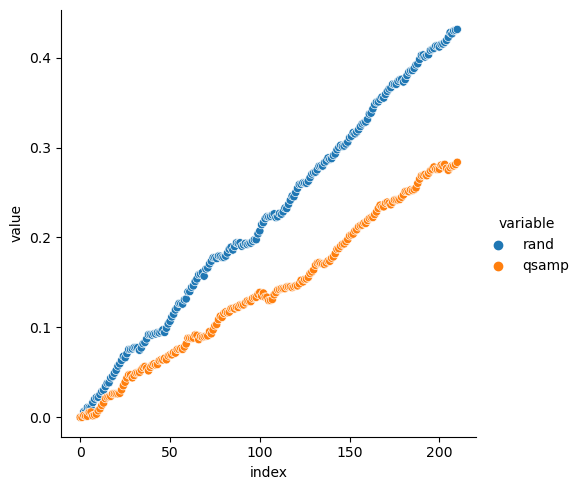

In [115]:
sns.relplot(
    data=pd.melt(
        pd.DataFrame({"rand": mean_diss_r, "qsamp": mean_diss_q}).reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
)
plt.show()

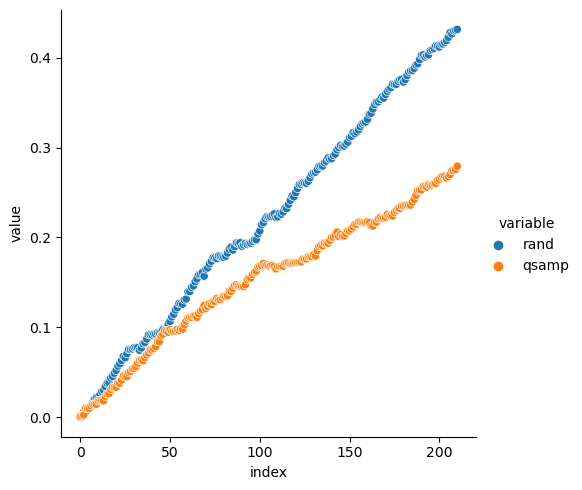

DONE


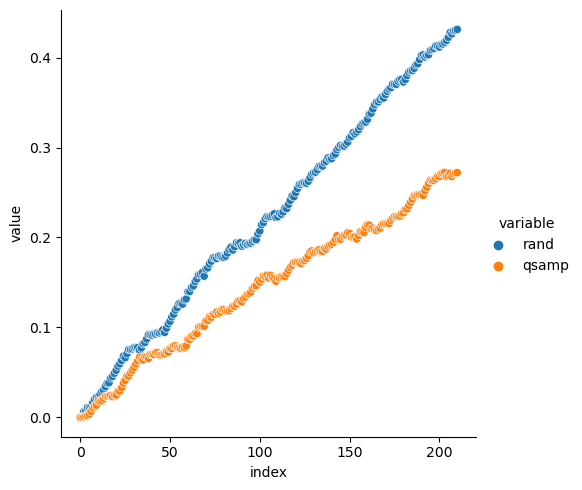

DONE


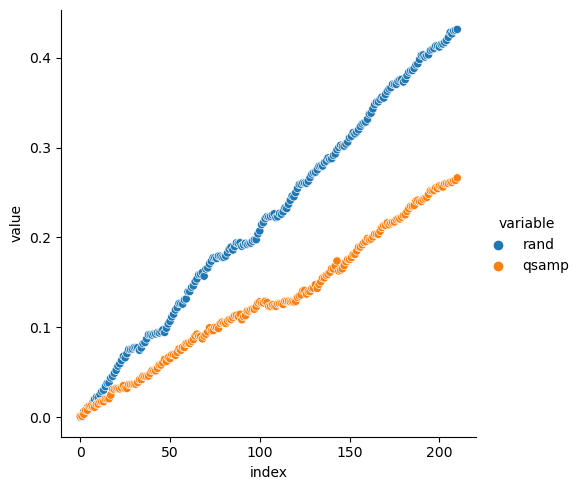

DONE


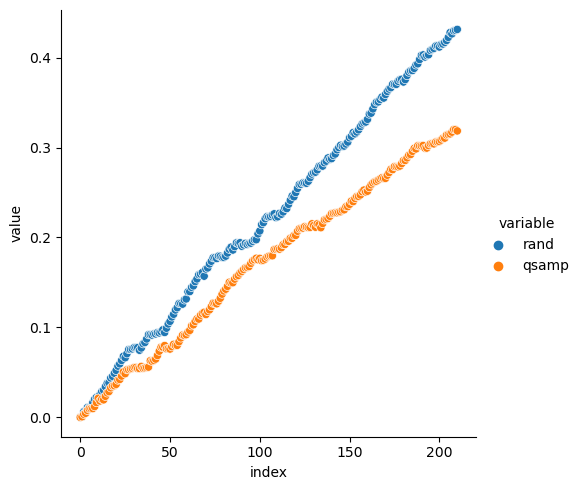

DONE


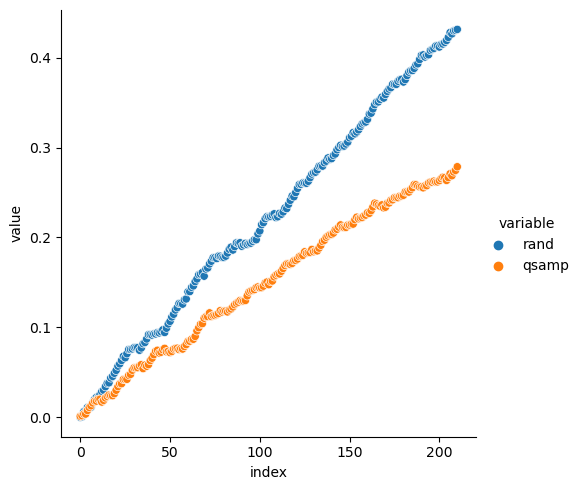

DONE


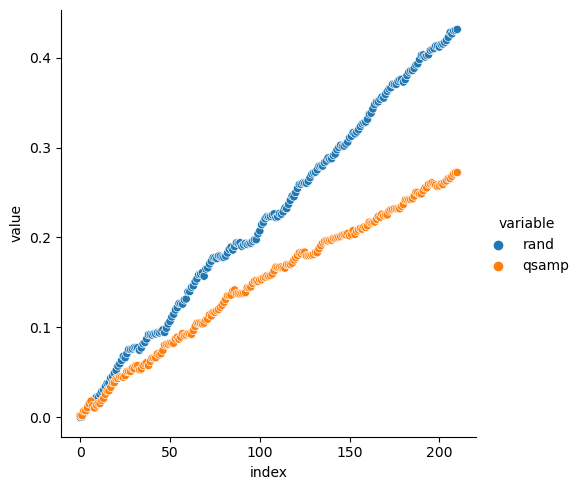

DONE


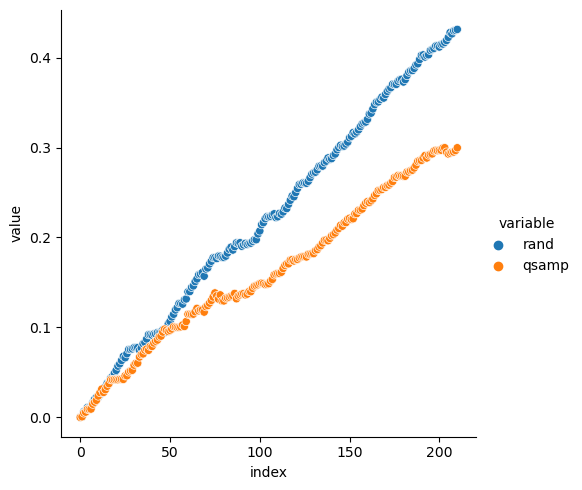

DONE


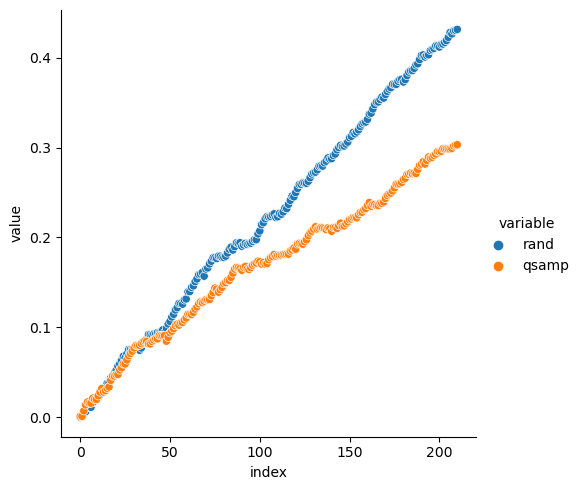

DONE


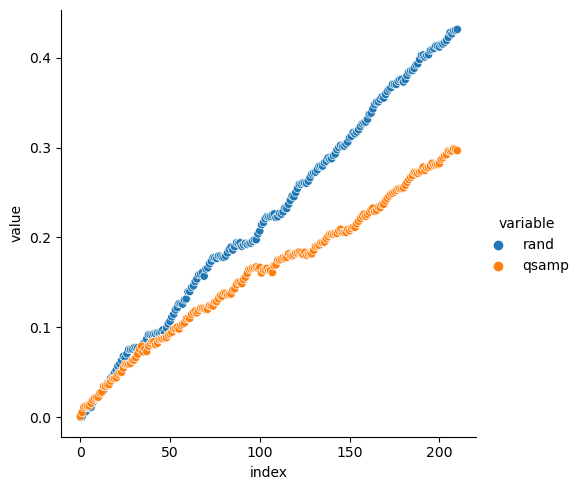

DONE


In [123]:
# permute the columns (Test)
for i in range(1,10):
    colsi = np.random.permutation(np.array(features))
    getDissonance_new(samples, 6, None, colsi, None)
    
    # chunk 1
    random.seed(10)
    new_samp = np.full_like(samples[0], fill_value="")
    vals = ["1", "2", "3", "4", "5"]
    mean_diss_r = list()
    for i in range(211):
        new_samp[i] = random.choice(vals)
        mean_diss_r.append(np.mean(Tr.cognet_obj.dissonance(sample=new_samp)))

    # chunk 2
    new_samp = np.full_like(samples[0], fill_value="")
    mean_diss_q = list()
    for i in range(211):
        prob_dict = Tr.model_obj.myQnet.predict_distribution(new_samp, i)
        new_samp[i] = sample_from_dict(prob_dict)
        mean_diss_q.append(np.mean(Tr.cognet_obj.dissonance(sample=new_samp)))

    # chunk 3   
    sns.relplot(
        data=pd.melt(
            pd.DataFrame({"rand": mean_diss_r, "qsamp": mean_diss_q}).reset_index(),
            id_vars="index",
        ),
        x="index",
        y="value",
        hue="variable",
    )
    plt.show()
    print("DONE")